Derived from notebook [aperezhortal/cv-splitting-by-earthquake-id](https://www.kaggle.com/aperezhortal/cv-splitting-by-earthquake-id)

In [1]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import LeaveOneGroupOut

from catboost import CatBoostRegressor

import seaborn as sns

import os

In [2]:
x_tr_scaled = pd.read_csv('../kaggle_project/kaggle_files/features/ind_segs/train/standard_138_scaled.csv', index_col=0)
y_tr = pd.read_csv('../kaggle_project/kaggle_files/features/ind_segs/train/ttf.csv',index_col=0)

In [3]:
segment_df = y_tr.copy()
segment_df['new_quake'] = segment_df.diff()>0
tmp = segment_df['new_quake'].apply(lambda x: 1 if x else 0)
segment_df['quake_id'] = tmp.cumsum()
segment_df.columns = ['y_train', 'new_quake', 'quake_id']

segment_df.head()

,y_train,new_quake,quake_id
0,1.430797,False,0
1,1.391499,False,0
2,1.353196,False,0
3,1.313798,False,0
4,1.274400,False,0


In [4]:
def get_model():
    kwargs = {'iterations':2000, 'loss_function':'MAE', 'boosting_type':'Plain', 'silent':True}
    selected_model = CatBoostRegressor(**kwargs) 
    
    return selected_model    

In [5]:
def create_quake_df(segment_df):
    quake_gb = segment_df.groupby('quake_id')

    quake_summary = {}
    for quake_id, quake in quake_gb:
        time_min = quake['y_train'].min()
        time_max = quake['y_train'].max()
        quake_duration = time_max-time_min
        num_segments = len(quake)
        segment_idxes = quake.index
        quake_summary[int(quake_id)] = [quake_id, time_min, time_max, quake_duration, num_segments, segment_idxes]

    quake_df = pd.DataFrame(quake_summary).T
    quake_df.columns = ['quake_id', 'time_min','time_max','quake_duration','num_segments','segment_idxes']
    
    return quake_df

def plot_segment_residual(segment_df, target='y_train', set_ax2_ylim=True):
    fig, ax1 = plt.subplots(figsize=(12,4), sharex=True, sharey=True)
    ax1.plot(segment_df[target])
    ax1.set_ylabel(target)
    ax1.set_xlabel("Segment #")

    ax2 = ax1.twinx() 
    ax2.plot( segment_df['validation_segment_preds'], color='r')
    ax2.set_ylabel('y_pred')
    
    # Force y_pred to use the same ylim as target
    if set_ax2_ylim:

        ax2.set_ylim(ax1.set_ylim())
    plt.show()

In [6]:
quake_df = create_quake_df(segment_df)

quake_df

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes
0,0,0.0284956,1.4308,1.4023,37,"Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
1,1,0.0357963,11.5301,11.4943,296,"Int64Index([ 37, 38, 39, 40, 41, 42, 43,..."
2,2,0.0337959,14.1774,14.1436,364,"Int64Index([333, 334, 335, 336, 337, 338, 339,..."
3,3,0.00639766,8.8514,8.845,228,"Int64Index([697, 698, 699, 700, 701, 702, 703,..."
4,4,0.0367983,12.6611,12.6243,325,"Int64Index([ 925, 926, 927, 928, 929, 930..."
5,5,0.0276957,8.0545,8.0268,207,"Int64Index([1250, 1251, 1252, 1253, 1254, 1255..."
6,6,0.0334984,7.0473,7.0138,181,"Int64Index([1457, 1458, 1459, 1460, 1461, 1462..."
7,7,0.0102978,16.1032,16.0929,414,"Int64Index([1638, 1639, 1640, 1641, 1642, 1643..."
8,8,0.00649738,7.8769,7.8704,203,"Int64Index([2052, 2053, 2054, 2055, 2056, 2057..."
9,9,0.0206955,9.6052,9.5845,247,"Int64Index([2255, 2256, 2257, 2258, 2259, 2260..."


In [65]:
group_kfold = LeaveOneGroupOut()

fold_splitter = group_kfold.split(x_tr_scaled,y_tr,segment_df['quake_id'])

train_errors = []
validation_errors = []
validation_segment_preds = []

for quake_id, (train_index, valid_index) in enumerate(fold_splitter):
    if quake_id in [0,16]: # 37 and 48 segments for these quakes
        train_errors.append(np.NaN)
        validation_errors.append(np.NaN)
        validation_segment_preds.extend([np.NaN]*len(valid_index))
        continue 

    print('Validation Earthquake:\t', quake_id,end="   ")

    train_signal, validation_signal = x_tr_scaled.iloc[train_index], x_tr_scaled.iloc[valid_index]
    train_quaketime, validation_quaketime = y_tr.iloc[train_index], y_tr.iloc[valid_index]
                
    selected_model = get_model()
    selected_model.fit(train_signal, train_quaketime.values.ravel())

    validation_segment_pred = selected_model.predict(validation_signal)
    train_error = mean_absolute_error(selected_model.predict(train_signal), train_quaketime)
    validation_error = mean_absolute_error(validation_segment_pred, validation_quaketime)
    
    train_errors.append(train_error)
    validation_errors.append(validation_error)
    validation_segment_preds.extend(validation_segment_pred)

    print('train_error: {0:.2f} \t validation_error: {1:.2f} '.format(train_error, validation_error))

Validation Earthquake:	 1   train_error: 1.70 	 validation_error: 1.73 
Validation Earthquake:	 2   train_error: 1.58 	 validation_error: 3.10 
Validation Earthquake:	 3   train_error: 1.69 	 validation_error: 1.27 
Validation Earthquake:	 4   train_error: 1.64 	 validation_error: 2.37 
Validation Earthquake:	 5   train_error: 1.64 	 validation_error: 2.20 
Validation Earthquake:	 6   train_error: 1.64 	 validation_error: 2.40 
Validation Earthquake:	 7   train_error: 1.46 	 validation_error: 4.03 
Validation Earthquake:	 8   train_error: 1.63 	 validation_error: 2.45 
Validation Earthquake:	 9   train_error: 1.72 	 validation_error: 1.00 
Validation Earthquake:	 10   train_error: 1.70 	 validation_error: 1.68 
Validation Earthquake:	 11   train_error: 1.71 	 validation_error: 1.53 
Validation Earthquake:	 12   train_error: 1.68 	 validation_error: 1.42 
Validation Earthquake:	 13   train_error: 1.67 	 validation_error: 1.60 
Validation Earthquake:	 14   train_error: 1.53 	 validation_

In [66]:
segment_df['validation_segment_preds'] = validation_segment_preds
segment_df['validation_segment_residuals'] = segment_df['y_train'] - segment_df['validation_segment_preds']

In [67]:
segment_df.dropna().head()

,y_train,new_quake,quake_id,validation_segment_preds,validation_segment_residuals
37,11.530097,True,1,8.525310,3.004787
38,11.490799,False,1,8.673415,2.817384
39,11.452497,False,1,8.559692,2.892804
40,11.413098,False,1,8.504732,2.908366
41,11.373699,False,1,8.995722,2.377977


In [68]:
errors_df = pd.DataFrame({'train_error':train_errors, 'validation_error':validation_errors})
errors_df.head()

,train_error,validation_error
0,NaN,NaN
1,1.698520,1.734873
2,1.575766,3.095700
3,1.693594,1.268380
4,1.641234,2.370874


## Inspect Train and Validation MAE by quake

Text(0.5, 0, 'quake_id')

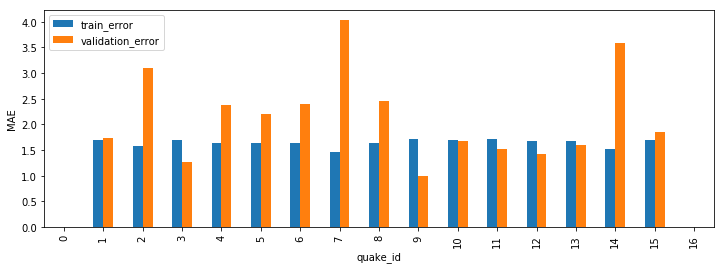

In [69]:
ax = errors_df[['train_error','validation_error']].plot(kind='bar', figsize=(12,4))
ax.set_ylabel('MAE')
ax.set_xlabel('quake_id')

## Inspecting Entire Training Set

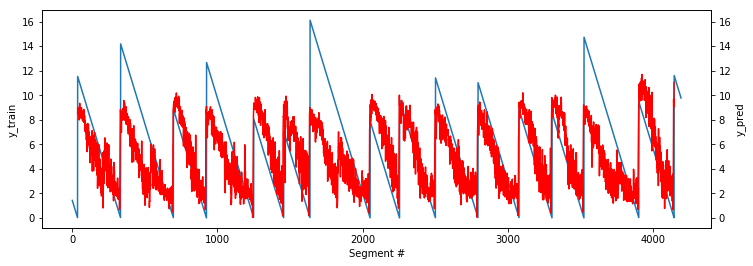

In [86]:
plot_segment_residual(segment_df)

## Inspect Individual Quakes

There are approximately 10 segments before the quake occurs that baseline models have consistently overestimated.

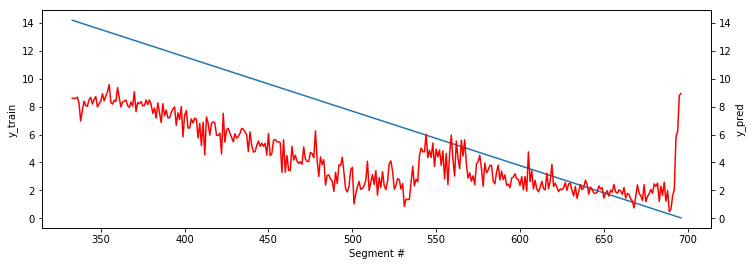

In [146]:
plot_segment_residual(segment_df.loc[quake_df.loc[2,'segment_idxes']])

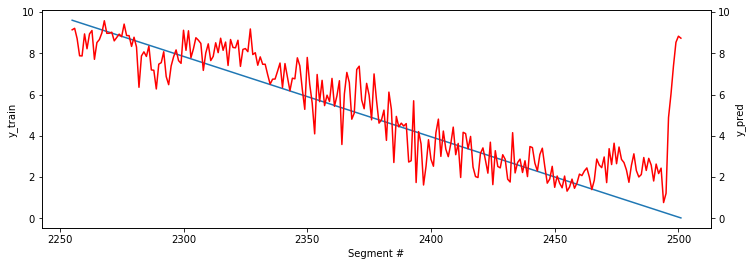

In [75]:
plot_segment_residual(segment_df.loc[quake_df.loc[9,'segment_idxes']])

In [77]:
quake_residuals = pd.concat([quake_df,errors_df], axis=1)
quake_residuals.head()

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes,train_error,validation_error
0,0,0.0284956,1.4308,1.4023,37,"Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8...",NaN,NaN
1,1,0.0357963,11.5301,11.4943,296,"Int64Index([ 37, 38, 39, 40, 41, 42, 43,...",1.698520,1.734873
2,2,0.0337959,14.1774,14.1436,364,"Int64Index([333, 334, 335, 336, 337, 338, 339,...",1.575766,3.095700
3,3,0.00639766,8.8514,8.845,228,"Int64Index([697, 698, 699, 700, 701, 702, 703,...",1.693594,1.268380
4,4,0.0367983,12.6611,12.6243,325,"Int64Index([ 925, 926, 927, 928, 929, 930...",1.641234,2.370874


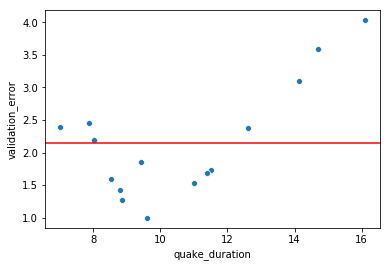

In [139]:
ax1 = sns.scatterplot(quake_residuals['quake_duration'], quake_residuals['validation_error'])
ax1.axhline(quake_residuals['validation_error'].mean(), c='r')

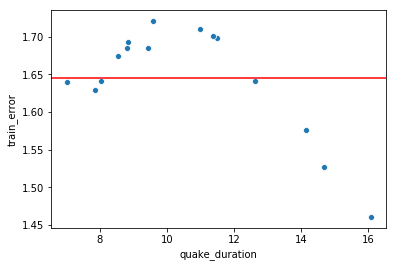

In [137]:
ax2 = sns.scatterplot(quake_residuals['quake_duration'], quake_residuals['train_error'])
ax2.axhline(quake_residuals['train_error'].mean(), c='r')

Text(0, 0.5, 'validation_error')

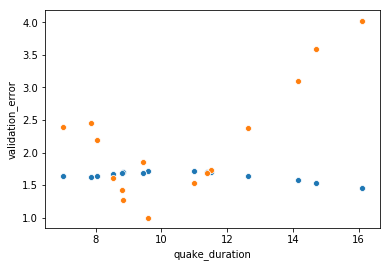

In [144]:
ax1 = sns.scatterplot(quake_residuals['quake_duration'], quake_residuals['train_error'])
ax1.set_ylabel('train_error')
ax2 = sns.scatterplot(quake_residuals['quake_duration'], quake_residuals['validation_error'])
ax2.set_ylabel('validation_error')

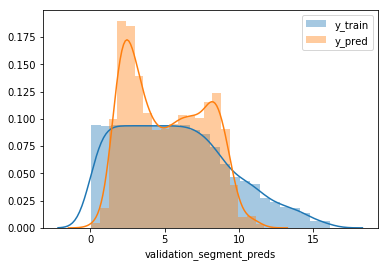

In [113]:
# Drop any rows without 'validation_segment_pred'
pred_hist = segment_df[['y_train','validation_segment_preds']].dropna()

plt.figure()
sns.distplot(pred_hist['y_train'], label='y_train', rug=False)
sns.distplot(pred_hist['validation_segment_preds'], label='y_pred', rug=False)
plt.legend()

There is a conspicuous absence of predictions with low TTF values

#  Predictions and Residuals for Entire Training Set

Smooth the prediction line by taking its moving average, and look for anti-monotonicity in the predictions.

In [114]:
segment_df['validation_segment_residual_2'] = segment_df.rolling(window=2)['validation_segment_residuals'].mean()
segment_df['validation_segment_residual_50'] = segment_df.rolling(window=50)['validation_segment_residuals'].mean()

In [115]:
segment_df['validation_segment_pred2'] = segment_df.rolling(window=2)['validation_segment_preds'].mean()
segment_df['validation_segment_pred50'] = segment_df.rolling(window=50)['validation_segment_preds'].mean()

## Predictions

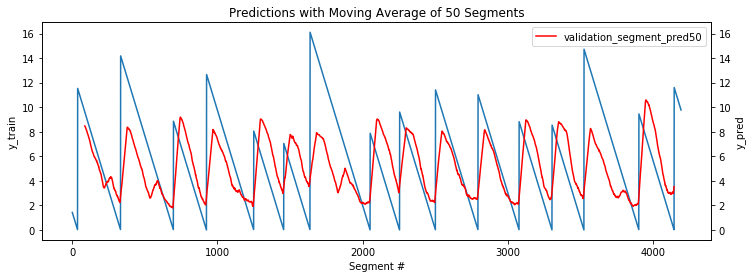

In [116]:
fig, ax1 = plt.subplots(figsize=(12,4), sharex=True, sharey=True)
ax1.plot(segment_df['y_train'])
ax1.set_ylabel('y_train')
ax1.set_xlabel("Segment #")
ax1.set_title('Predictions with Moving Average of 50 Segments')

ax2 = ax1.twinx() 
ax2.plot( segment_df['validation_segment_pred50'], color='r')
ax2.set_ylabel('y_pred')

ax2.set_ylim(ax1.set_ylim())

plt.legend()
plt.show()

Quakes 1, 2, 7, and 15 have shown noticeable double sign change on the first derivative of the predicted values for baseline models.  Events in these moving average windows are adding time back on to the TTF countdown.

## Residuals
MA Smoothed Residuals For All of Train

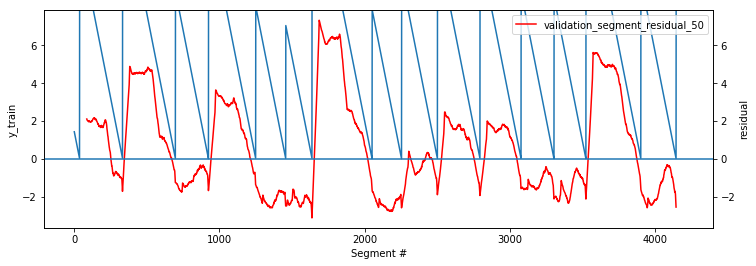

In [118]:
fig, ax1 = plt.subplots(figsize=(12,4), sharex=True, sharey=True)
ax1.plot(segment_df['y_train'])
ax1.set_ylabel('y_train')
ax1.set_xlabel("Segment #")

ax2 = ax1.twinx() 
ax2.plot( segment_df['validation_segment_residual_50'], color='r')
ax2.set_ylabel('residual')

# Force y_pred to use the same ylim as target
ax1.set_ylim(ax2.set_ylim())

plt.axhline(y=0)
plt.legend()
plt.show()

The pattern of underestimating the large TTF values and overestimating the small TTF values becomes more obvious when the the sign of the error is kept.  Ideally we want the residuals centered around 0. 

## Plotting Residuals and TTF for each Quake

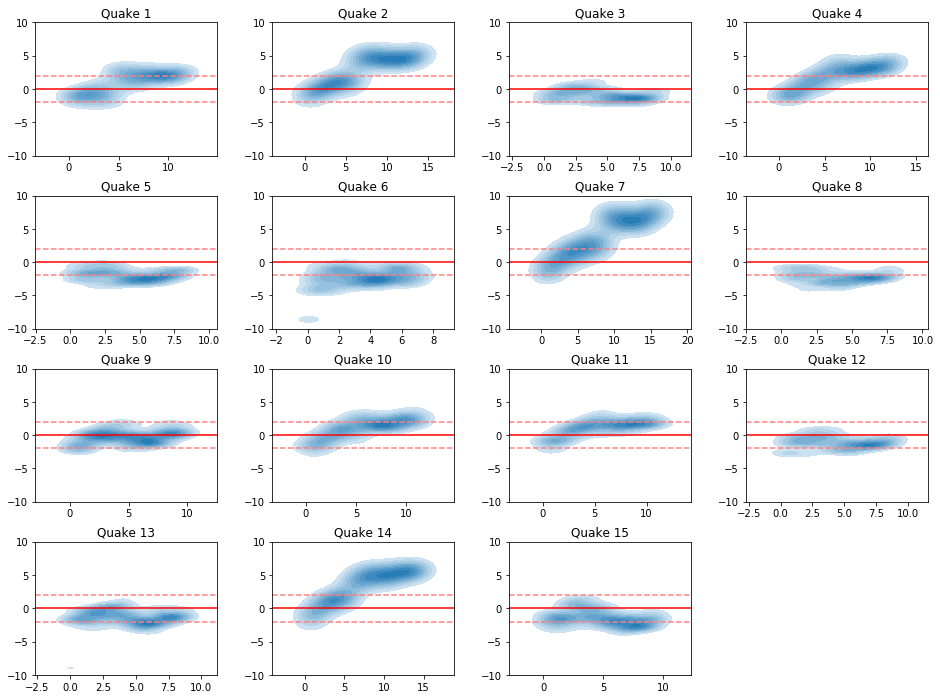

In [120]:
error_margin = 2

fig = plt.figure(figsize=(16,12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(1,16):
    sub_segment = segment_df.loc[quake_df.loc[i,'segment_idxes']]
    
    plt.subplot(4, 4, i)
    ax1 = sns.kdeplot(sub_segment['y_train'], sub_segment['validation_segment_residuals'], 
                      shade=True, shade_lowest=False)
    ax1.set_title('Quake {}'.format(i))
    ax1.set_ylim(-10,10)
    ax1.set_ylabel('')
    ax1.set_xlabel('')
    
    plt.axhline(y=0, color='#FF0000')
    plt.axhline(y=error_margin, color='#FF8080', linestyle= '--')
    plt.axhline(y=error_margin*(-1), color='#FF8080', linestyle= '--')

Mass above the red line are underestimates for the baseline model.  Mass below the line are overestimates.